# Transfer Learning for Sentiment Analysis

# 0. Imports

In [1]:
import os, pickle

# for keeping track of loops
from tqdm import tqdm

# basic libraries
import numpy as np
import pandas as pd

# import pytorch
import torch
import torch.nn as nn

# import pytorch modules
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# imports from transformers
import transformers
from transformers import AutoModel, BertTokenizerFast

# sklearn modules
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# setting the device to "mps" instead of default "cpu"
# device = torch.device("mps" if torch.backends.mps.is_available else "cpu")
device = torch.device("cuda" if torch.cuda.is_available else "cpu")


print(device)

cuda


# 1. Preparing Data

In [3]:
raw_data_dir = '/kaggle/input/sentiment-analysis-dataset'
raw_data_dir

'/kaggle/input/sentiment-analysis-dataset'

In [4]:
df_train = pd.read_csv(os.path.join(raw_data_dir, 'train.csv'), encoding= 'unicode_escape')
df_test = pd.read_csv(os.path.join(raw_data_dir, 'test.csv'), encoding= 'unicode_escape')

df_train.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [5]:
# check out column info for train
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            27481 non-null  object 
 1   text              27480 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         27481 non-null  object 
 4   Time of Tweet     27481 non-null  object 
 5   Age of User       27481 non-null  object 
 6   Country           27481 non-null  object 
 7   Population -2020  27481 non-null  int64  
 8   Land Area (Km²)   27481 non-null  float64
 9   Density (P/Km²)   27481 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 2.1+ MB


In [6]:
# check out column info for test
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4815 entries, 0 to 4814
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            3534 non-null   object 
 1   text              3534 non-null   object 
 2   sentiment         3534 non-null   object 
 3   Time of Tweet     3534 non-null   object 
 4   Age of User       3534 non-null   object 
 5   Country           3534 non-null   object 
 6   Population -2020  3534 non-null   float64
 7   Land Area (Km²)   3534 non-null   float64
 8   Density (P/Km²)   3534 non-null   float64
dtypes: float64(3), object(6)
memory usage: 338.7+ KB


The test data has the `selected_text` column missing. So, we will be using the `text` column for sentiment analysis.

In [7]:
df_train.dropna(subset=['text'], inplace=True)
df_test.dropna(subset=['text'], inplace=True)

# select the columns we need
df_train = df_train[['text', 'sentiment']]
df_test = df_test[['text', 'sentiment']]

# print the shape info for the dataframes
print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")

Train shape: (27480, 2)
Test shape: (3534, 2)


In [8]:
# we check the class distribution for the train set
df_train['sentiment'].value_counts(normalize=True)

neutral     0.404549
positive    0.312300
negative    0.283151
Name: sentiment, dtype: float64

In [9]:
# we check the class distribution for the test set
df_test['sentiment'].value_counts(normalize=True)

neutral     0.404641
positive    0.312111
negative    0.283248
Name: sentiment, dtype: float64

Since, they are identically distributed, we can use the same data loader for both the tasks.

In [10]:
# we create a dictionary that maps the labels to integers
label2int = {'negative': 0, 'neutral': 1, 'positive': 2}

# we create a dictionary that maps the integers back to labels
int2label = {v: k for k, v in label2int.items()}

In [11]:
# we create a new column called "label" which maps the text labels to integers using the dictionary we created above
df_train['label'] = df_train['sentiment'].map(label2int)
df_test['label'] = df_test['sentiment'].map(label2int)

# we check the head of the train dataframe
df_train.head()

,text,sentiment,label
0,"I`d have responded, if I were going",neutral,1
1,Sooo SAD I will miss you here in San Diego!!!,negative,0
2,my boss is bullying me...,negative,0
3,what interview! leave me alone,negative,0
4,"Sons of ****, why couldn`t they put them on t...",negative,0


In [12]:
# we first split the train set into train and validation sets

train_text, val_text, train_labels, val_labels = train_test_split(df_train['text'], df_train['label'], test_size=0.15, random_state=42)

# set the test text, label pairs
test_text, test_labels = df_test['text'], df_test['label']

# print the shape of the train, val, and test sets
print(f"Train shape: {train_text.shape}")
print(f"Validation shape: {val_text.shape}")
print(f"Test shape: {test_text.shape}")

Train shape: (23358,)
Validation shape: (4122,)
Test shape: (3534,)


# 2. BERT Tokenization

In [2]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased', return_dict=False)

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
# check the tokenizer of sample texts
sample_text = ["this is a sample text to be tokenized", "we will be using bert-base tokenizer for this"]

# encode the sample text
sample_text_id = tokenizer.batch_encode_plus(sample_text, padding=True, return_token_type_ids=False)

# print the encoded text
print(sample_text_id)

{'input_ids': [[101, 2023, 2003, 1037, 7099, 3793, 2000, 2022, 19204, 3550, 102, 0, 0], [101, 2057, 2097, 2022, 2478, 14324, 1011, 2918, 19204, 17629, 2005, 2023, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


This simultaneously stores the `input_ids` and `attention_mask` for the input sentence. The `input_ids` are the token ids of the input sentence and the `attention_mask` is a binary mask indicating the position of the padded indices so that the model does not attend to them.

## 2.1 Tokenization

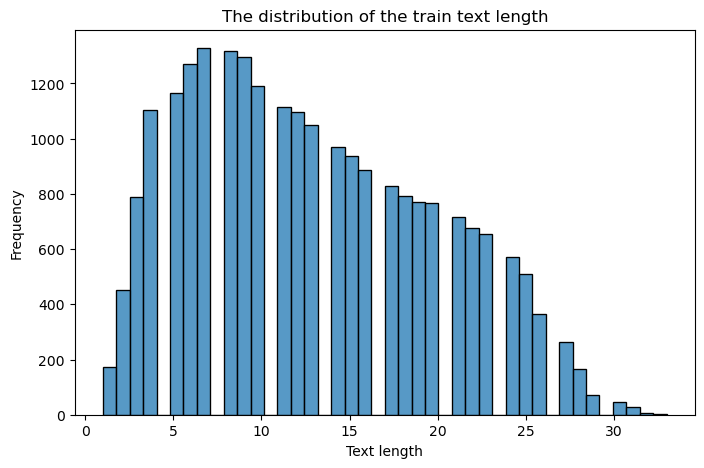

In [16]:
# extract the length of all the texts in the train set
train_text_len = [len(text.split()) for text in train_text]

# plot the distribution of the train text length
plt.figure(figsize=(8, 5))
sns.histplot(train_text_len)
plt.title('The distribution of the train text length')
plt.xlabel('Text length')
plt.ylabel('Frequency')
plt.show()

In [17]:
# find the maximum length of the texts in train_text
max_len = max([len(text.split()) for text in train_text])
print(f"Maximum length of the texts in train_text: {max_len}")

Maximum length of the texts in train_text: 33


Based on the above plot, we can observe that the maximum length of the input sentence is less than `35`. So, we will be using a maximum length of `35` for padding the input sentence.

In [18]:
# set the maximum length of the sequences
max_seq_len = 35

# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length=max_seq_len,
    padding=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length=max_seq_len,
    padding=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length=max_seq_len,
    padding=True,
    truncation=True,
    return_token_type_ids=False
)

## 2.2 Convert Integer Sequences to Tensors

In [19]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

## 2.3 Create DataLoaders

In [20]:
# define a batch size
batch_size = 32

## for train set
# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

## for validation set
# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# 3. Fine-Tuning BERT

In [21]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

# define the model
class BERT_Arch(nn.Module):
        def __init__(self, bert):
            super(BERT_Arch, self).__init__()
            self.bert = bert
            # dropout layer
            self.dropout = nn.Dropout(0.1)
            # relu activation function
            self.relu = nn.ReLU()
            # dense layer 1
            self.fc1 = nn.Linear(768, 512)
            # dense layer 2 (Output layer)
            self.fc2 = nn.Linear(512, 3)
            # softmax activation function
            self.softmax = nn.LogSoftmax(dim=1)
    
        # define the forward pass
        def forward(self, sent_id, mask):
            # pass the inputs to the model
            _, cls_hs = self.bert(sent_id, attention_mask=mask)
            x = self.fc1(cls_hs)
            x = self.relu(x)
            x = self.dropout(x)
            # output layer
            x = self.fc2(x)
            # apply softmax activation
            x = self.softmax(x)
            return x

In [40]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

# define the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

## 3.1 Find Class Weights

In [41]:
#compute the class weights
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_labels),
                                        y = train_labels
)

class_weights_dict = dict(zip(np.unique(train_labels), class_weights))
print(class_weights_dict)

{0: 1.1773778920308484, 1: 0.8254001908194636, 2: 1.0648249452954048}


In [42]:
# convert class weights to tensor
weights= torch.tensor(class_weights, dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy = nn.NLLLoss(weight=weights)

## 3.2 Define the `train` and `evaluate` functions

In [43]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0.0, 0.0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 200 batches.
    if step % 200 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [44]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

## 3.3 Train the Model

In [45]:
# create a directory named models, to store the saved models
models_dir = os.path.join(os.getcwd(), 'models')
! mkdir $models_dir

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
mkdir: cannot create directory ‘/kaggle/working/models’: File exists


In [46]:
# number of training epochs
epochs = 50

# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), os.path.join('models', 'saved_weights.pt'))
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 50
  Batch   200  of    730.
  Batch   400  of    730.
  Batch   600  of    730.

Evaluating...
  Batch    50  of    129.
  Batch   100  of    129.

Training Loss: 1.009
Validation Loss: 0.945

 Epoch 2 / 50
  Batch   200  of    730.
  Batch   400  of    730.
  Batch   600  of    730.

Evaluating...
  Batch    50  of    129.
  Batch   100  of    129.

Training Loss: 0.932
Validation Loss: 0.912

 Epoch 3 / 50
  Batch   200  of    730.
  Batch   400  of    730.
  Batch   600  of    730.

Evaluating...
  Batch    50  of    129.
  Batch   100  of    129.

Training Loss: 0.919
Validation Loss: 0.872

 Epoch 4 / 50
  Batch   200  of    730.
  Batch   400  of    730.
  Batch   600  of    730.

Evaluating...
  Batch    50  of    129.
  Batch   100  of    129.

Training Loss: 0.901
Validation Loss: 0.913

 Epoch 5 / 50
  Batch   200  of    730.
  Batch   400  of    730.
  Batch   600  of    730.

Evaluating...
  Batch    50  of    129.
  Batch   100  of    129.

Training Loss: 0.89

In [47]:
# load weights of best model
best_model_path = os.path.join('models', 'saved_weights.pt')
model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

# 4. Evaluation on the Test Data

In [48]:
# get predictions for test data
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)

print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.58      0.77      0.66      1001
           1       0.70      0.45      0.55      1430
           2       0.64      0.74      0.69      1103

    accuracy                           0.63      3534
   macro avg       0.64      0.66      0.63      3534
weighted avg       0.65      0.63      0.62      3534



In [49]:
# confusion matrix
pd.crosstab(test_y, preds)

col_0,0,1,2
row_0,,,
0,773,117,111
1,441,645,344
2,125,159,819
